In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoLarsCV

from matplotlib import rc
from scipy import optimize
import scipy.stats as stats

## Data Cleanup

In [121]:
CG_table = pd.read_csv("methylation_used.csv", header=None)
CG_table = CG_table.drop(columns = 0)
# print("First shape: ", CG_table.shape)
# print(CG_table)
# CG_table_short = CG_table[91:]

isna = CG_table.isna().any()
ones = np.ones((CG_table.shape[1]))
keep = ones-isna
keep = keep.to_numpy()
keep = keep.astype(bool)

CG_table = CG_table.dropna(axis = 'columns')

UCLA_CG_table = CG_table[0:147]
Wolves_CG_table = CG_table[147:]

print("Keep: ", len(keep), "\n", keep)

Keep:  5609 
 [ True False  True ...  True  True False]


In [122]:
traits_short = pd.read_csv("traits_used.csv", header=None)

UCLA_traits = traits_short[0:147]
Wolves_traits = traits_short[147:]

print(UCLA_traits)

                           0         1                                 2   \
0     DogWolf00109_S110.CGmap  3.12E+13          English Springer Spaniel   
1     DogWolf00110_S105.CGmap  3.12E+13          English Springer Spaniel   
2      DogWolf00111_S89.CGmap  3.12E+13          English Springer Spaniel   
3      DogWolf00112_S88.CGmap  3.12E+13  3/4 Alaskan Sled Dog+ 1/4 Saluki   
4      DogWolf00113_S82.CGmap  3.12E+13  3/4 Alaskan Sled Dog+ 1/4 Saluki   
..                        ...       ...                               ...   
142  PK9-31201050607843.CGmap  3.12E+13                   Irish Wolfhound   
143  PK9-31201050607844.CGmap  3.12E+13                          Chiuahua   
144  PK9-31301050607662.CGmap  3.13E+13                       Bullmastiff   
145     PK9-31_UCLACore.CGmap  3.10E+13                    FRENCH BULLDOG   
146     PK9-32_UCLACore.CGmap  3.10E+13                    FRENCH BULLDOG   

       3        4        5     6    7    8       9         10      11      

In [123]:
name_temp = UCLA_traits.loc[:,0]
age_temp = UCLA_traits.loc[:,3]
sex_temp = UCLA_traits.loc[:,4]
spayed_temp = UCLA_traits.loc[:,6]
weight_temp = UCLA_traits.loc[:,7]
hetero_temp = UCLA_traits.loc[:,9]
FOH_temp = UCLA_traits.loc[:,10]
pred_ages_temp = UCLA_traits.loc[:,12]
wolves_age_temp = Wolves_traits.loc[:,3]

names = []
ages = []
sexes = []
spayeds = []
weights = []
heteros = []
FOHs = []
wolves_ages = []


for i in range(len(name_temp)):
    names.append(name_temp[i])
    ages.append(age_temp[i])
    sexes.append(sex_temp[i])
    spayeds.append(spayed_temp[i])
    weights.append(weight_temp[i])
    heteros.append(hetero_temp[i])
    FOHs.append(FOH_temp[i])
    
for i in range(len(wolves_age_temp)):
    wolves_ages.append(wolves_age_temp[i+147])

names = np.array(names)
ages = np.array(ages)
sexes = np.array(sexes)
weights = np.array(weights)
spayeds = np.array(spayeds)
heteros = np.array(heteros)
FOHs = np.array(FOHs)
wolves_ages = np.array(wolves_ages)

print(pred_ages_temp)

0       6.6615
1      11.6405
2       6.4752
3       0.5993
4       1.1253
        ...   
142     1.4500
143     0.4588
144     2.1971
145     2.6865
146    -0.6436
Name: 12, Length: 147, dtype: float64


In [6]:
triplicates = [[25,26,54],[27,28,55],[29,30,56],[31,32,57],\
               [33,34,58],[35,36,59],[37,38,60],[39,40,61],\
               [41,42,62],[43,44,63],[45,46,64],[47,48,65],\
               [49,50,66],[52,53,146]]

triplicates

[[25, 26, 54],
 [27, 28, 55],
 [29, 30, 56],
 [31, 32, 57],
 [33, 34, 58],
 [35, 36, 59],
 [37, 38, 60],
 [39, 40, 61],
 [41, 42, 62],
 [43, 44, 63],
 [45, 46, 64],
 [47, 48, 65],
 [49, 50, 66],
 [52, 53, 146]]

In [7]:
# coverages = pd.read_csv("dog_counts_217.csv", header=None)
# coverages_short = coverages[91:]
# coverages_short = coverages_short.drop(columns = 0)
# coverages_short = coverages_short.to_numpy()

# print("Coverages: \n", coverages_short.shape)
# print(coverages_short)

# print("Keep: \n", keep.shape)
# print(keep)

In [8]:
# coverages_short_keep = coverages_short[:,keep]
# print(coverages_short_keep.shape)
# print(coverages_short_keep)

# coverages_mean = coverages_short_keep.mean(axis = 0)
# print("Means: \n", coverages_mean)

In [9]:
def parser(coverage_means, quantile):
    coverage_means_q = statistics.quantiles(coverage_means, n=quantile)[quantile-2]
    best = coverage_means > coverage_means_q
    return best

In [10]:
# best = parser(coverages_mean, 3)
# print(best)

In [67]:
methylation = UCLA_CG_table.to_numpy()
IDs = methylation[:,0]
methylation = np.delete(methylation, 0, 1)
# methylation = methylation[:,best]

print(methylation.shape)
print(methylation)

(147, 2358)
[[0.930715935 0.03125 0.083333333 ... 0.626865672 0.765625
  0.8904109590000001]
 [0.91609589 0.073529412 0.030075188 ... 0.761904762 0.773913043
  0.811926606]
 [0.935727788 0.098214286 0.025423729 ... 0.602094241 0.76875
  0.8060200670000001]
 ...
 [0.806818182 0.004366812 0.007633588 ... 0.590909091 0.7657657659999999
  0.669724771]
 [0.948837209 0.0 0.011235955 ... 0.611111111 0.6911764709999999
  0.810714286]
 [0.923018868 0.002544529 0.05362776 ... 0.728323699 0.7300884959999999
  0.8259803920000001]]


## LARS Prediction

In [103]:
def get_predictions(X_train, Y_train):
    loo = LeaveOneOut()
    predicted_ages = []

    for train_index, test_index in loo.split(X_train):
        X_retrain, X_retest = X_train[train_index], X_train[test_index]
        
        # MODIFY X_retrain and Y_retrain
        IDcheck = np.ones(len(IDs))
        dupIDs = IDs
        for i in range(len(IDcheck)):
            if IDs[test_index[0]] == dupIDs[i]:
                IDcheck[i] = 0
        IDcheck = np.delete(IDcheck, test_index[0])
        
        X_retrain2 = X_retrain[IDcheck.astype(bool)]
        print(X_retrain2.shape)
        
        Y_retrain, Y_retest = Y_train[train_index], Y_train[test_index]
        Y_retrain2 = Y_retrain[IDcheck.astype(bool)]
        
        lars = LassoLars(alpha = 0.001)
        lars.fit(X_retrain2, Y_retrain2)
        predicted_ages.append(lars.predict(X_retest)[0])
    
    return predicted_ages

#Try lassolarsCV

In [109]:
print(ages)

# lars_predict = get_predictions(methylation, ages)
lars_predict_sqrt = get_predictions(methylation, np.sqrt(ages))

[ 6.8 12.9  5.6  1.1  1.1  1.1  4.3 11.8  0.9  0.8  2.4 16.5 10.1  9.7
  1.7  4.9 13.3 11.3  9.4  3.4  6.8  8.8 11.3  1.1  5.1  2.   2.  10.2
 10.2  9.7  9.7  9.5  9.5  1.3  1.3  2.1  2.1 10.8 10.8  9.8  9.8  9.3
  9.3  4.4  4.4  2.   2.   5.   5.   0.7  0.7  2.   0.4  0.4  2.  10.2
  9.7  9.5  1.3  2.1 10.8  9.8  9.3  4.4  2.   5.   0.7  2.1  1.3  6.
  9.8  2.2  3.6  1.   4.4  5.9  2.8  5.5  0.4  4.1 13.3  5.5  4.3  1.6
 10.4  3.6  8.   9.9  0.7  1.6 11.8  6.5  0.9  2.2  5.8 12.1  7.3 12.1
  5.1 10.9  4.2  0.8  8.5  3.7  2.6  1.9  0.9  1.1  0.5  1.3  6.7  9.3
  3.5  9.   0.3  8.8  2.4  5.8  0.8  2.   4.6  4.9  7.7  9.   4.3  3.5
  3.7  3.1  2.1 12.2  3.5 10.2 12.1  4.5 10.9  4.2  2.5  4.8  4.2  8.5
  3.  11.8  1.   2.3  1.7  2.   0.4]
(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.859e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=1.161e-03, with an active set of 92 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.842e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=2.252e-03, with an active set of 62 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=1.

(146, 2358)
(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.803e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=3.076e-03, with an active set of 50 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=3.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.780e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 137 iterations, i.e. alpha=1.086e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 146 iterations, i.e. alpha=1.070e-03, with an active set of 96 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.791e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.930e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=3.232e-03, with an active set of 47 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=4.002e-03, with an active set of 35 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=2.246e-03, with an active set of 63 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 122 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.604e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=2.071e-03, with an active set of 72 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 44 iterations, i.e. alpha=3.870e-03, with an active set of 36 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=2.478e-03, with an active set of 64 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 140 iterations, i.e. alpha=1.077e-03, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=3.347e-03, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=3.601e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=2.957e-03, with an active set of 51 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=1.261e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 128 iterations, alpha=1.250e-03, previous alpha=1.250e-03, with an active set of 95 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=3.041e-03, with an 

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=2.681e-03, with an active set of 59 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 100 iterations, i.e. alpha=1.601e-03, with an active set of 78 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 101 iterations, i.e. alpha=

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=2.467e-03, with an active set of 59 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=2.465e-03, with an active set of 60 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 110 iterations, i.e. alpha=1

(145, 2358)
(145, 2358)
(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=2.766e-03, with an active set of 53 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=2.387e-03, with an active set of 55 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=2.

(145, 2358)
(145, 2358)
(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.724e-03, with an active set of 37 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 86 iterations, i.e. alpha=2.188e-03, with an active set of 70 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=4.219e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=2.475e-03, with an active set of 61 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=2.

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=4.033e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=2.204e-03, with an active set of 66 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=4.523e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=2.678e-03, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 111 iterations, i.e. alpha=1

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=4.096e-03, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=2.376e-03, with an active set of 59 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 121 iterations, i.e. alpha=1

(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=2.820e-03, with an active set of 54 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=2.807e-03, with an active set of 56 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(145, 2358)
(145, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.989e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=3.137e-03, with an active set of 55 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=3.

(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=3.602e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=2.996e-03, with an active set of 52 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(145, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.812e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=2.119e-03, with an active set of 71 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=1

(145, 2358)
(146, 2358)

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=1.710e-03, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 129 iterations, i.e. alpha=1.239e-03, with an active set of 91 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 203 iterations, i.e. alpha=1.515e-03, with an active set of 97 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 205 iterations, i.e. alpha=1.513e-03, with an active set of 99 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is n

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 131 iterations, i.e. alpha=1.156e-03, with an active set of 97 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.768e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=3

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=3.516e-03, with an active set of 43 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=2.128e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.944e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=2.339e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)
(146, 2358)

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.767e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 99 iterations, i.e. alpha=1.906e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=3.


(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.804e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=3.804e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=3.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 59 iterations, i.e. alpha=3.173e-03, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=2.389e-03, with an active set of 61 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.792e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=2.199e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 44 iterations, i.e. alpha=4.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=4.124e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=2.408e-03, with an active set of 59 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 105 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.853e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 134 iterations, i.e. alpha=1.161e-03, with an active set of 90 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 135 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=3.766e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=1.119e-03, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=2

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.803e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=2.212e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=3.481e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 114 iterations, i.e. alpha=1.499e-03, with an active set of 90 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 142 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.781e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=1.958e-03, with an active set of 75 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 135 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.783e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.780e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=3.321e-03, with an active set of 46 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=1.288e-03, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.803e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1.942e-03, with an active set of 70 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '


(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=2.156e-03, with an active set of 66 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=2.156e-03, with an active set of 67 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=3.692e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=2.100e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 151 iterations, alpha=1.193e-03, previous alpha=1.193e-03, with an active set of 90 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=2.990e-03, with an active set of 50 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=2.990e-03, with an a

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1.795e-03, with an active set of 78 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=1.794e-03, with an active set of 79 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=3.776e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=3.118e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.953e-03, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=2.461e-03, with an active set of 61 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=3.644e-03, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=2.992e-03, with an active set of 51 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)
(146, 2358)

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=3.836e-03, with an active set of 36 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=3.835e-03, with an active set of 37 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 86 iterations, i.e. alpha=2.


(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=3.103e-03, with an active set of 50 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=3.099e-03, with an active set of 51 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no 

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.504e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=1.916e-03, with an active set of 73 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 115 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=3.293e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 120 iterations, i.e. alpha=1.330e-03, with an active set of 94 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.805e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=1.103e-03, with an active set of 94 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 59 iterations, i.e. alpha=3.468e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 137 iterations, i.e. alpha=1.171e-03, with an active set of 89 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 138 iterations, i.e. alpha=

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.831e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=2.172e-03, with an active set of 68 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=2.474e-03, with an active set of 64 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=2.474e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.827e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=1.958e-03, with an active set of 75 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 137 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 107 iterations, i.e. alpha=1.530e-03, with an active set of 81 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=1.529e-03, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=

(146, 2358)
(146, 2358)

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.630e-03, with an active set of 44 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=2.559e-03, with an active set of 59 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 112 iterations, i.e. alpha=1


(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=2.868e-03, with an active set of 50 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=2.868e-03, with an active set of 51 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.815e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=2.138e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=4.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=2.077e-03, with an active set of 68 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 97 iterations, alpha=1.948e-03, previous alpha=1.946e-03, with an active set of 72 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=3.561e-03, with an ac

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 131 iterations, i.e. alpha=1.173e-03, with an active set of 91 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=1.165e-03, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.868e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 131 iterations, i.e. alpha=1.157e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=1.581e-03, with an active set of 76 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 103 iterations, i.e. alpha=1.497e-03, with an active set of 79 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3

(146, 2358)
(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.818e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=1.150e-03, with an active set of 91 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.826e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=2.139e-03, with an active set of 69 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=3.626e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=3.624e-03, with an active set of 43 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=2.

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=3.882e-03, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=2.208e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 128 iterations, i.e. alpha=1

(146, 2358)
(146, 2358)


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.852e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=1.152e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '


In [115]:
def get_median_abs_error(prediction, actual):
    errors = []
    for i in range(len(prediction)):
        difference = np.abs(prediction[i] - actual[i])
        errors.append(difference)
    return statistics.median(errors)

def get_r_value(predicted_ages_list, actual_ages_list):
    r_value = np.corrcoef(actual_ages_list, predicted_ages_list)[0,1]
    return r_value

def get_r_squared(predicted_ages_list, actual_ages_list):
    return (get_r_value(predicted_ages_list, actual_ages_list)**2)

def plot_predictions(predicted_ages_list, actual_ages_list):
    plt.plot(actual_ages_list, predicted_ages_list, 'ko')
    plt.ylabel("Predicted Age")
    plt.xlabel("Actual Age")
    plt.title("Lasso LARS Model of Predicted Age (Square Root Transform)")
    plt.text(8, 2, "Median Absolute Error: 0.6522")
    plt.text(8, 1, "R squared: 0.8939")
    plt.plot(actual_ages_list, actual_ages_list, 'r--')
    plt.savefig('Predicted_vs_actual_lars_sqrt_unduplicated.png', dpi = 300)
    plt.show()
    print("R squared: ", get_r_squared(predicted_ages_list, actual_ages_list))
    print("R value: ", get_r_value(predicted_ages_list, actual_ages_list))
    print("Median Absolute Error: ", get_median_abs_error(predicted_ages_list, actual_ages_list))

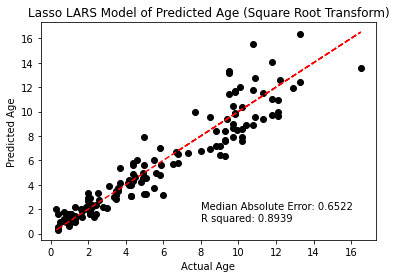

R squared:  0.8938768363438215
R value:  0.9454505996316368
Median Absolute Error:  0.6522345393833326


In [116]:
plot_predictions(np.square(lars_predict_sqrt), ages)
# Predict square root of age

In [117]:
list(lars_predict)

[6.661468857328449,
 11.640501420093877,
 6.475165477104342,
 0.5992670200685852,
 1.1252856353186673,
 1.3671014309419172,
 3.015124393905721,
 13.54184743912353,
 -0.9502415716916977,
 1.487191166801498,
 3.405093399679993,
 12.734632167474002,
 11.286649802653496,
 8.878291121412706,
 1.8645004233438263,
 5.254245222329637,
 12.001505920106334,
 12.338414123509946,
 10.262917302622007,
 3.929325302956511,
 6.220953057114215,
 7.9330248456396495,
 9.472849518080247,
 1.7058987808031905,
 5.1530929634640525,
 0.2577091961360374,
 2.71510674488073,
 9.174819434125427,
 7.273479688630921,
 3.897039646601808,
 7.589745205129136,
 12.098380468471095,
 12.231612419635546,
 1.3825609994705825,
 2.297899732664286,
 2.0058768336142414,
 1.8501508961424635,
 15.01540193080492,
 10.567764267506838,
 8.269784686280719,
 10.437294771173967,
 6.588993510697668,
 6.664136059947214,
 3.9592992841500103,
 5.588461064164253,
 3.3133151848822386,
 3.0697226435282614,
 7.924515254476766,
 3.475840442951

Text(0.5, 0, 'Individual')

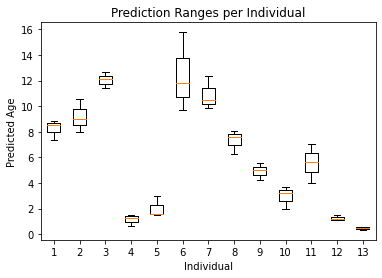

In [20]:
triplicate_ranges = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[],\
                     8:[], 9:[], 10:[], 11:[], 12:[], 13:[]}
for x in triplicate_ranges:
    temp = []
    for y in triplicates[x]:
        temp.append(np.square(lars_predict_sqrt[y]))
    triplicate_ranges[x] = temp
    
fig, ax = plt.subplots()
ax.boxplot(triplicate_ranges.values())
ax.set_xticklabels(triplicate_ranges.keys())
ax.title.set_text('Prediction Ranges per Individual')
ax.set_ylabel('Predicted Age')
ax.set_xlabel('Individual')
# plt.savefig('Prediction_ranges.png', dpi = 300)

In [79]:
triplicate_range_for_median = []
for x in triplicate_ranges:
    triplicate_range_for_median.append(np.std(triplicate_ranges[x]))
    
triplicate_range_for_median = np.array(triplicate_range_for_median)
print("Median of Standard Deviation for Triplicates:", statistics.median(triplicate_range_for_median))

Median of Standard Deviation for Triplicates: 0.673237622289822


In [20]:
list(lars_predict)

[6.661468857328449,
 11.640501420093877,
 6.475165477104342,
 0.5992670200685852,
 1.1252856353186673,
 1.3671014309419172,
 3.015124393905721,
 13.54184743912353,
 -0.9502415716916977,
 1.487191166801498,
 3.405093399679993,
 12.734632167474002,
 11.286649802653496,
 8.878291121412706,
 1.8645004233438263,
 5.254245222329637,
 12.001505920106334,
 12.338414123509946,
 10.262917302622007,
 3.929325302956511,
 6.220953057114215,
 7.9330248456396495,
 9.472849518080247,
 1.7058987808031905,
 5.1530929634640525,
 1.4267039088319535,
 2.3949050059478263,
 10.332032060558328,
 7.71579772906935,
 12.022562753745373,
 6.689853389091237,
 12.028535783852865,
 11.80793875275549,
 1.1395736366857707,
 2.295707729898487,
 2.075573346011081,
 1.9038342268852366,
 14.673966807697187,
 10.415102257660998,
 8.192966728332028,
 10.293511883531718,
 6.569300208888478,
 6.813362469723304,
 4.023948232522712,
 6.514442060690573,
 2.9188899154948507,
 3.124983050354106,
 7.144776818433945,
 3.861085924834

## Pacemaker Prediction

In [21]:
from EpigeneticPacemaker.EpigeneticPacemaker import EpigeneticPacemaker

In [22]:
def pearson_correlation(meth_matrix: np.array, phenotype: np.array) -> np.array:
    """calculate pearson correlation coefficient between rows of input matrix and phenotype"""
    # calculate mean for each row and phenotype mean
    matrix_means = np.mean(meth_matrix, axis=0)
    phenotype_mean = np.mean(phenotype)

    # subtract means from observed values
    transformed_matrix = np.transpose(meth_matrix) - matrix_means.reshape([-1,1])
    transformed_phenotype = phenotype - phenotype_mean

    # calculate covariance
    covariance = np.sum(transformed_matrix * transformed_phenotype, axis=1)
#     print("Covariance shape: ", covariance.shape, "\n", covariance)
    sums = np.sum(transformed_matrix ** 2, axis=1)
    variance_meth = []
    for i in sums:
        variance_meth.append(np.sqrt(i))
    variance_meth = np.array(variance_meth)
#     variance_meth = np.sqrt(np.sum(transformed_matrix ** 2, axis=1))
#     print("Variance meth shape: ", variance_meth.shape, "\n", variance_meth)
    variance_phenotype = np.sqrt(np.sum(transformed_phenotype ** 2))
#     print("Variance pheno shape: ", variance_phenotype.shape, "\n", variance_phenotype)

    return covariance / (variance_meth * variance_phenotype)

In [23]:
# get the absolute value of the correlation coefficient
abs_pcc_coefficients = abs(pearson_correlation(methylation, ages))

# print("Abs Pearson: ", abs_pcc_coefficients)

In [24]:
# return list of site indices with a high absolute correlation coefficient
training_sites = np.where(abs_pcc_coefficients > .6)[0]

print(training_sites)

[   5   22   53   54   59   60   61   62   64   67   97  114  115  154
  183  194  203  204  205  206  211  229  230  234  235  243  247  251
  263  265  301  304  305  306  310  319  364  365  366  378  409  410
  413  425  465  524  528  529  532  534  553  556  571  572  576  591
  593  594  600  601  622  625  626  627  630  631  658  674  681  682
  703  704  734  744  745  750  761  762  790  791  792  793  812  830
  843  887  905  915  916  964  965  966  967  968  970  971  975  977
  978 1014 1015 1060 1080 1352 1656 1665 1693 1695 1810 1811 1935 1936
 1937 2000 2001 2002 2008 2009 2031 2112 2113 2126 2259 2325]


In [25]:
from matplotlib import rc
from scipy import optimize
import scipy.stats as stats

def plot_known_predicted_ages(known_ages, predicted_ages, label=None):
    # define optimization function
    def func(x, a, b, c):
        return a * np.asarray(x)**0.5 + c
    def func_2(x, a, b, c):
        return a * np.asarray(x) + c
    def func_3(x, a, b, c):
        return a * np.log(np.asarray(x)) + c
    
    # fit trend line
    popt, pcov = optimize.curve_fit(func, [1 + x for x in known_ages], predicted_ages)
    popt_2, pcov_2 = optimize.curve_fit(func_2, [1 + x for x in known_ages], predicted_ages)
    popt_3, pcov_3 = optimize.curve_fit(func_3, [1 + x for x in known_ages], predicted_ages)
    
    # get r squared
    rsquared = r2(predicted_ages, func([1 + x for x in known_ages], *popt))
    rsquared_2 = r2(predicted_ages, func_2([1 + x for x in known_ages], *popt_2))
    rsquared_3 = r2(predicted_ages, func_3([1 + x for x in known_ages], *popt_3))
    
    # format plot label
    plot_label = f'$f(x)={popt[0]:.2f}x^{{1/2}} {popt[2]:.2f}, R^{{2}}={rsquared:.2f}$'
    plot_label_2 = f'$f(x)={popt_2[0]:.2f}x {popt_2[2]:.2f}, R^{{2}}={rsquared_2:.2f}$'
    plot_label_3 = f'$f(x)={popt_3[0]:.2f}ln(x) {popt_3[2]:.2f}, R^{{2}}={rsquared_3:.2f}$'
    
    # initialize plt plot
    fig, ax = plt.subplots(figsize=(12,12))
    # plot trend line
    ax.plot(sorted(known_ages), func(sorted([1 + x for x in known_ages]), *popt), 'r--', label=plot_label)
    ax.plot(sorted(known_ages), func_2(sorted([1 + x for x in known_ages]), *popt_2), 'b--', label=plot_label_2)
    ax.plot(sorted(known_ages), func_3(sorted([1 + x for x in known_ages]), *popt_3), 'g--', label=plot_label_3)
    
    # scatter plot
    ax.scatter(known_ages, predicted_ages, marker='o', alpha=0.8, color='k')
    ax.set_title(label, fontsize=18)
    ax.set_xlabel('Chronological Age', fontsize=16)
    ax.set_ylabel('Epigenetic State', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
#     plt.savefig('Epi_pacemaker.png', dpi=300)
    plt.show()
    
# def plot_known_predicted_ages(known_ages, predicted_ages, label=None):
#     # define optimization function
#     def func_3(x, a, b, c):
#         return a * np.log(np.asarray(x)) + c
#     # fit trend line
#     popt, pcov = optimize.curve_fit(func_3, [1 + x for x in known_ages], predicted_ages)
#     # get r squared
#     rsquared = r2(predicted_ages, func_3([1 + x for x in known_ages], *popt))
#     # format plot label
#     plot_label = f'$f(x)={popt[0]:.2f}ln(x) {popt[2]:.2f}, R^{{2}}={rsquared:.2f}$'
#     # initialize plt plot
#     fig, ax = plt.subplots(figsize=(12,12))
#     # plot trend line
#     ax.plot(sorted(known_ages), func_3(sorted([1 + x for x in known_ages]), *popt), 'g--', label=plot_label)
#     # scatter plot
#     ax.scatter(known_ages, predicted_ages, marker='o', alpha=0.8, color='k')
#     ax.set_title(label, fontsize=18)
#     ax.set_xlabel('Chronological Age', fontsize=16)
#     ax.set_ylabel('Epigenetic State', fontsize=16)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     ax.legend(fontsize=16)
#     plt.savefig('Epi_pacemaker.png')
#     plt.show()
    
# use latex formatting for plots
rc('text', usetex=False)

def r2(x,y):
    # return r squared
    return stats.pearsonr(x,y)[0] **2

In [26]:
# initialize the EPM model 
epm = EpigeneticPacemaker(iter_limit=100, error_tolerance=0.00001)

table = methylation
short_table = np.transpose(table[:,training_sites])
print("Short Table: ", short_table.shape)

# fit the model using the training data
epm.fit(short_table, ages)

# generate predicted ages using the test data
pacemaker_state_predict = epm.predict(short_table)

Short Table:  (124, 147)


C:\Users\patri\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


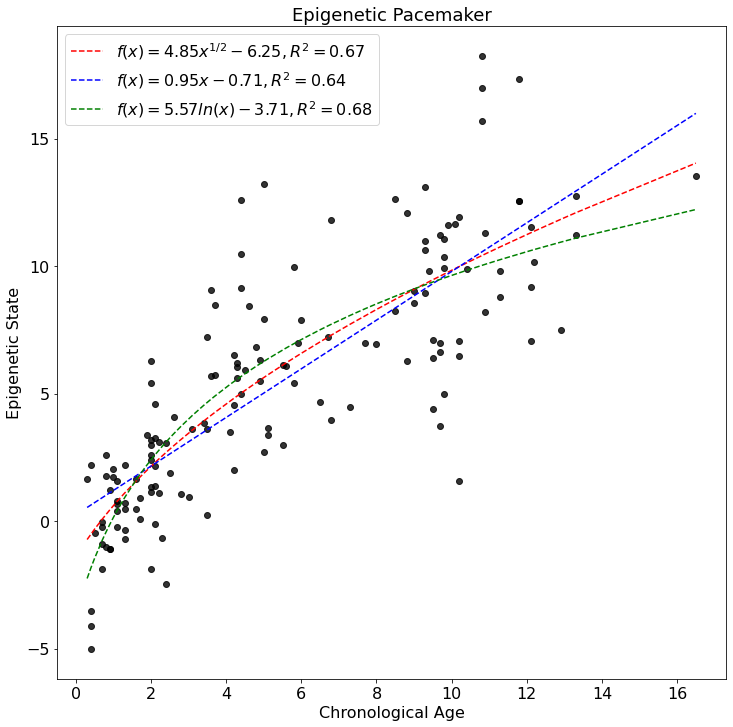

In [27]:
plot_known_predicted_ages(ages, pacemaker_state_predict, 'Epigenetic Pacemaker')
# Predict square root of age
# Put in table - both predictions + actual

## Significance Tests

In [124]:
import statsmodels.api as sm

In [125]:
sexes_int = []
weights_int = []

male_num = 0
female_num = 0
other_num = 0

for i in range(len(sexes)):
    if sexes[i][0] == 'M':
        sexes_int.append(0)
        male_num += 1
    elif sexes[i][0] == 'F':
        sexes_int.append(1)
        female_num += 1
    else:
        print(i)
        other_num += 1
        
for weight in weights:
    weights_int.append(float(weight))

sexes_int = np.array(sexes_int)
print(sexes_int.shape)
print("Males: ", male_num)
print("Females: ", female_num)
print("Others: ", other_num)

(147,)
Males:  67
Females:  80
Others:  0


In [126]:
spayeds_int = []

for j in range(len(spayeds)):
    if spayeds[j] == 'nan':
        spayeds_int.append(0)
    elif spayeds[j][0] == 'Y' or spayeds[j][0] == 'y':
        spayeds_int.append(1)
    elif spayeds[j][1] == 'E' or spayeds[j][1] == 'e':
        spayeds_int.append(1)
    elif spayeds[j][0] == 'S' or spayeds[j][0] == 's':
        spayeds_int.append(1)
    else:
        spayeds_int.append(0)
        
spayeds_int = np.array(spayeds_int)

In [127]:
# age_sexes = ages * sexes_int
age_weights = ages * weights_int
# age_spayed = ages * spayeds_int
# age_hetero = ages * heteros
# age_FOH = ages * FOHs

In [128]:
stack = np.stack((ages, age_weights), axis = 1)

# Instead of age-squared, use square root of age

In [129]:
stack_df = pd.DataFrame(stack, columns = ['Age', 'Age*Weight'])

print(stack_df)

      Age  Age*Weight
0     6.8       238.0
1    12.9       580.5
2     5.6       252.0
3     1.1        49.5
4     1.1        46.2
..    ...         ...
142   1.0       130.0
143   2.3        27.6
144   1.7       185.3
145   2.0        60.0
146   0.4         3.6

[147 rows x 2 columns]


**Lars Predictions**

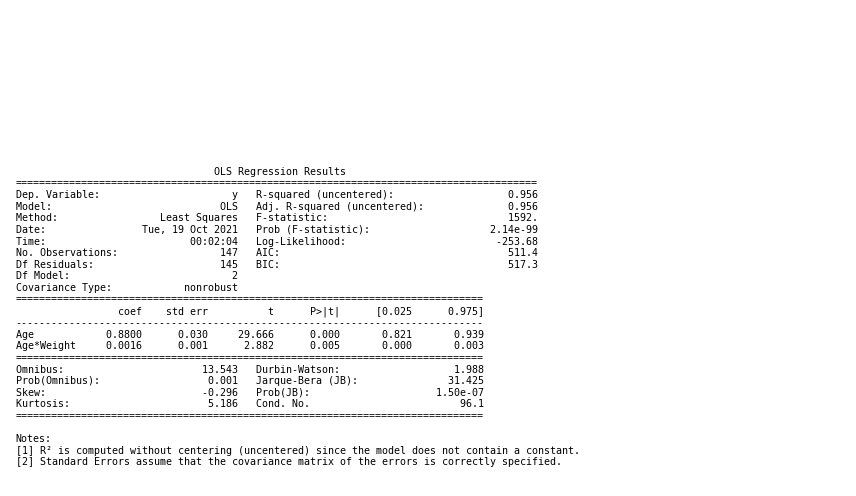

In [130]:
lars_sqrt_model = sm.OLS(lars_predict, stack_df)
lars_sqrt_fit = lars_sqrt_model.fit()
lars_sqrt_fit.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lars_sqrt_fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
# plt.savefig('Lars_Transform_Statsmodels_only.png', dpi=300)

# Put this in docs (export figure), and fix the labeling

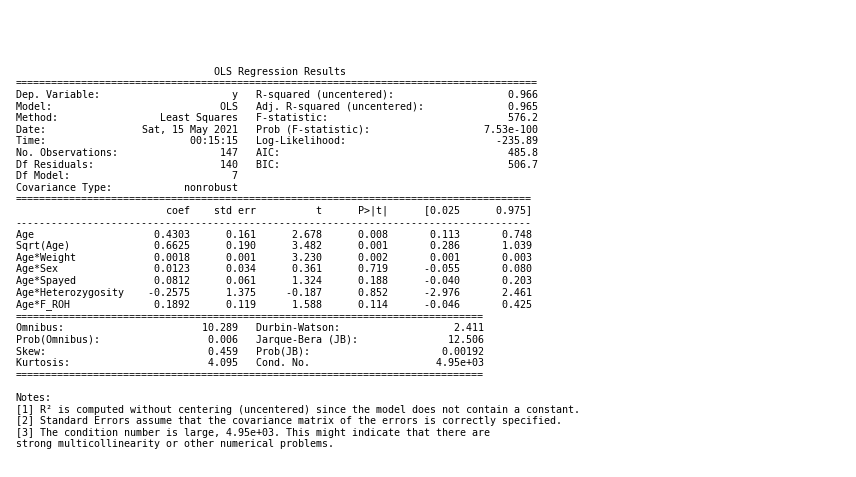

In [72]:
lars_model = sm.OLS(lars_predict, stack_df)
lars_fit = lars_model.fit()
lars_fit.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lars_fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('Lars_Statsmodels_no_sqrt.png')

# Put this in docs (export figure), and fix the labeling

**Pacemaker Predictions**

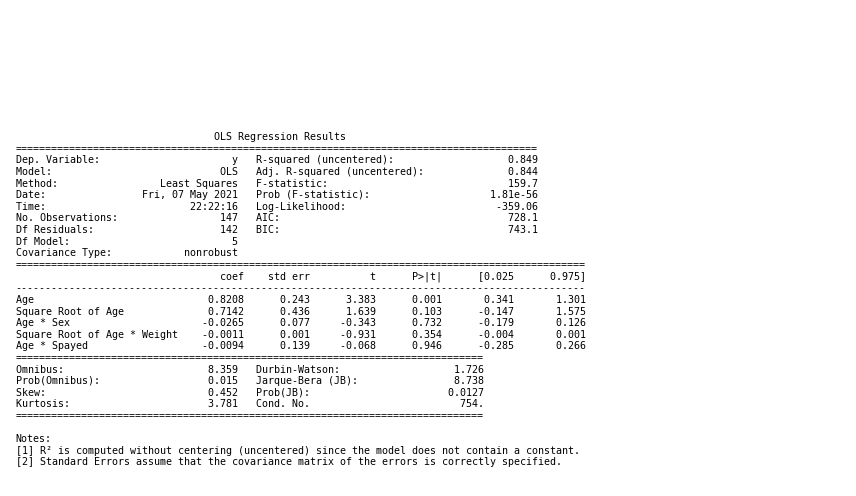

In [35]:
pacemaker_model = sm.OLS(pacemaker_state_predict, stack_df)
pacemaker_fit = pacemaker_model.fit()
pacemaker_fit.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(pacemaker_fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('Pacemaker_Statsmodels.png')

## Predicting Wolves

R squared:  0.6836444734239215
R value:  0.8268279587821892
Median Absolute Error:  1.2380399102925206


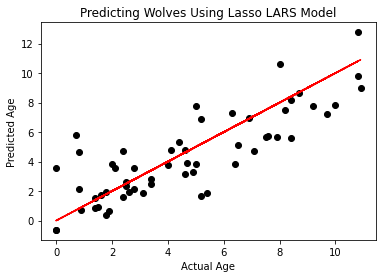

In [78]:
wolves_methylation = Wolves_CG_table

wolves_predict = LassoLars(alpha = 0.02)
wolves_predict.fit(methylation, ages)
predictions = wolves_predict.predict(wolves_methylation)

plt.plot(wolves_ages, predictions, 'ko')
plt.plot(wolves_ages, wolves_ages, 'r--')
plt.title('Predicting Wolves Using Lasso LARS Model')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.savefig('Wolves_predictions.png', dpi=300)

print("R squared: ", get_r_squared(predictions, wolves_ages))
print("R value: ", get_r_value(predictions, wolves_ages))
print("Median Absolute Error: ", get_median_abs_error(predictions, wolves_ages))

In [ ]:
# Look for the triplicates. For each one, find the range of age predictions (min to max)